#  <a id='0'>Team_8:Movies Recommender System  Solution</a> 

# Overview

![](https://hips.hearstapps.com/hmg-prod.s3.amazonaws.com/images/best-movies-1614634680.jpg?crop=1.00xw:1.00xh;0,0&resize=980:*)

##   Problem Statement

The rapid growth of data collection has led to a new era of information. Data is being used to create more efficient systems and this is where Recommendation Systems come into play.  Recommendation Systems are a type of **information filtering systems** as they improve the quality of search results and provides items that are more relevant to the search item or are realted to the search history of the user. 

They are used to predict the **rating** or **preference** that a user would give to an item. Almost every major tech company has applied them in some form or the other: Amazon uses it to suggest products to customers, YouTube uses it to decide which video to play next on autoplay, and Facebook uses it to recommend pages to like and people to follow. 
Moreover,  companies like Netflix and Spotify  depend highly on the effectiveness of their recommendation engines for their business and sucees.

Recommender systems have gained significant usage in a number of industries and when efficiently use they help the firms generate a huge amount of revenue and help them gain a competitive advantage over their competitors. 

***For example, Data from Netflix's site shows that 80% of what people watch comes from their recommendation algorithm ("Netflix Research", 2022). As a result, recommender systems generate over $1 billion per year of Netflix's revenue.***


The main objective of this project is to construct a recommendation algorithm based on content or collaborative filtering, capable of accurately predicting how a user will rate a movie they have not yet viewed based on their historical preferences. 


> *  **Content Based Filtering**- They suggest similar items based on a particular item. This system uses item metadata, such as genre, director, description, actors, etc. for movies, to make these recommendations. The general idea behind these recommender systems is that if a person liked a particular item, he or she will also like an item that is similar to it.


> *  **Collaborative Filtering**- This system matches persons with similar interests and provides recommendations based on this matching. Collaborative filters do not require item metadata like its content-based counterparts.

##   Data Overview

This dataset consists of several million 5-star ratings obtained from users of the online MovieLens movie recommendation service. The MovieLens dataset has long been used by industry and academic researchers to improve the performance of explicitly-based recommender systems, and now you get to as well!

For this Challenge, we'll be using a special version of the MovieLens dataset which has enriched with additional data, and resampled for fair evaluation purposes.

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/MyDrive/kaggle"

%cd /content/gdrive/MyDrive/kaggle

!kaggle competitions download -c edsa-movie-recommendation-2022

!unzip \*.zip  && rm *.zip

from google.colab import output
output.clear()

# Importing Libraries

In [2]:
import warnings
warnings.simplefilter(action='ignore')

import pandas as pd
import numpy as np
import re

# visualisation libraries
from plotly.offline import init_notebook_mode, plot, iplot
import plotly.graph_objs as go
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import seaborn as sns

# **Loading Data**

In [3]:
movies_df = pd.read_csv('movies.csv')
imdb_df = pd.read_csv('imdb_data.csv')
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
links_df = pd.read_csv('links.csv')
tags_df = pd.read_csv('tags.csv')
genome_tags_df = pd.read_csv('genome_tags.csv')
genome_scores_df = pd.read_csv('genome_scores.csv')

# **Data Description**

* genome_scores.csv - a score mapping the strength between movies and tag-related properties.
* genome_tags.csv - user assigned tags for genome-related scores.
* imdb_data.csv - Additional movie metadata scraped from IMDB using the links.csv file.
* links.csv - File providing a mapping between a MovieLens ID and associated IMDB and TMDB IDs.
* sample_submission.csv - Sample of the submission format for the hackathon.
* tags.csv - User assigned for the movies within the dataset.
* test.csv - The test split of the dataset. Contains user and movie IDs with no rating data.
* train.csv - The training split of the dataset. Contains user and movie IDs with associated rating data.

### Overview of Dataframes

In [4]:
#show full value of dataframe
pd.set_option("display.max_rows", None, "display.max_columns", None)

In [5]:
#check the shape of the data
shape = {'Genome scores': genome_scores_df.shape,
            'Genome tags': genome_tags_df.shape,
            'IMDB': imdb_df.shape,
            'Links': links_df.shape,
            "Movies": movies_df.shape,
            'Tags': tags_df.shape,
            'Train': train_df.shape,
            'Test': test_df.shape}

df_shape = pd.DataFrame(list(shape.items()), columns=['Data Frame', 'Shape'])
df_shape

,Data Frame,Shape
0,Genome scores,"(15584448, 3)"
1,Genome tags,"(1128, 2)"
2,IMDB,"(27278, 6)"
3,Links,"(62423, 3)"
4,Movies,"(62423, 3)"
5,Tags,"(1093360, 4)"
6,Train,"(10000038, 4)"
7,Test,"(5000019, 2)"


In [6]:
#show full value of dataframe
pd.set_option("display.max_rows", None, "display.max_columns", None)

# Display the first 5 entries in each dataframe 
print("movies data:")
display(movies_df.head())
print("imdb data:")
display(imdb_df.head())
print("tags data:")
display(tags_df.head())
print("train data:")
display(train_df.head())

# Count the number of unique entries for features of interest
unique_movies = len(movies_df['movieId'].unique().tolist())
unique_tags = len(tags_df['tag'].unique().tolist())
unique_users = len(train_df['userId'].unique().tolist())
unique_directors = len(imdb_df['director'].unique().tolist())
unique_actors = len(imdb_df['title_cast'].unique().tolist())

# Create a dataframe to store the number of unique entries for features of interest
unique = pd.DataFrame({"movies": [unique_movies],
                       "tags" : [unique_tags],
                       "users": [unique_users],
                       "directors" : [unique_directors],
                       "actors" : [unique_actors]}, index=['unique_entries'])

print('number of unique entries for features of interest')
display(unique.transpose())

# Determine and display the min and max ratings received
min_rating = train_df.rating.min()
max_rating = train_df.rating.max()
print('Lowest rating: {}'.format(min_rating))
print('Highest rating: {}'.format(max_rating))

movies data:


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


imdb data:


,movieId,title_cast,director,runtime,budget,plot_keywords
0,1,Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...,John Lasseter,81.0,"$30,000,000",toy|rivalry|cowboy|cgi animation
1,2,Robin Williams|Jonathan Hyde|Kirsten Dunst|Bra...,Jonathan Hensleigh,104.0,"$65,000,000",board game|adventurer|fight|game
2,3,Walter Matthau|Jack Lemmon|Sophia Loren|Ann-Ma...,Mark Steven Johnson,101.0,"$25,000,000",boat|lake|neighbor|rivalry
3,4,Whitney Houston|Angela Bassett|Loretta Devine|...,Terry McMillan,124.0,"$16,000,000",black american|husband wife relationship|betra...
4,5,Steve Martin|Diane Keaton|Martin Short|Kimberl...,Albert Hackett,106.0,"$30,000,000",fatherhood|doberman|dog|mansion


tags data:


,userId,movieId,tag,timestamp
0,3,260,classic,1439472355
1,3,260,sci-fi,1439472256
2,4,1732,dark comedy,1573943598
3,4,1732,great dialogue,1573943604
4,4,7569,so bad it's good,1573943455


train data:


,userId,movieId,rating,timestamp
0,5163,57669,4.0,1518349992
1,106343,5,4.5,1206238739
2,146790,5459,5.0,1076215539
3,106362,32296,2.0,1423042565
4,9041,366,3.0,833375837


number of unique entries for features of interest


,unique_entries
movies,62423
tags,73051
users,162541
directors,11787
actors,17144


Lowest rating: 0.5
Highest rating: 5.0


# Observations 
* Our trainset consists of 10000038 movie ratings, 162541 unique users, 11787 directors, 17144 actors, and a total of 62423 movies.

# **Exploratory** **Data** **analysis** 



## **Popular Genres**

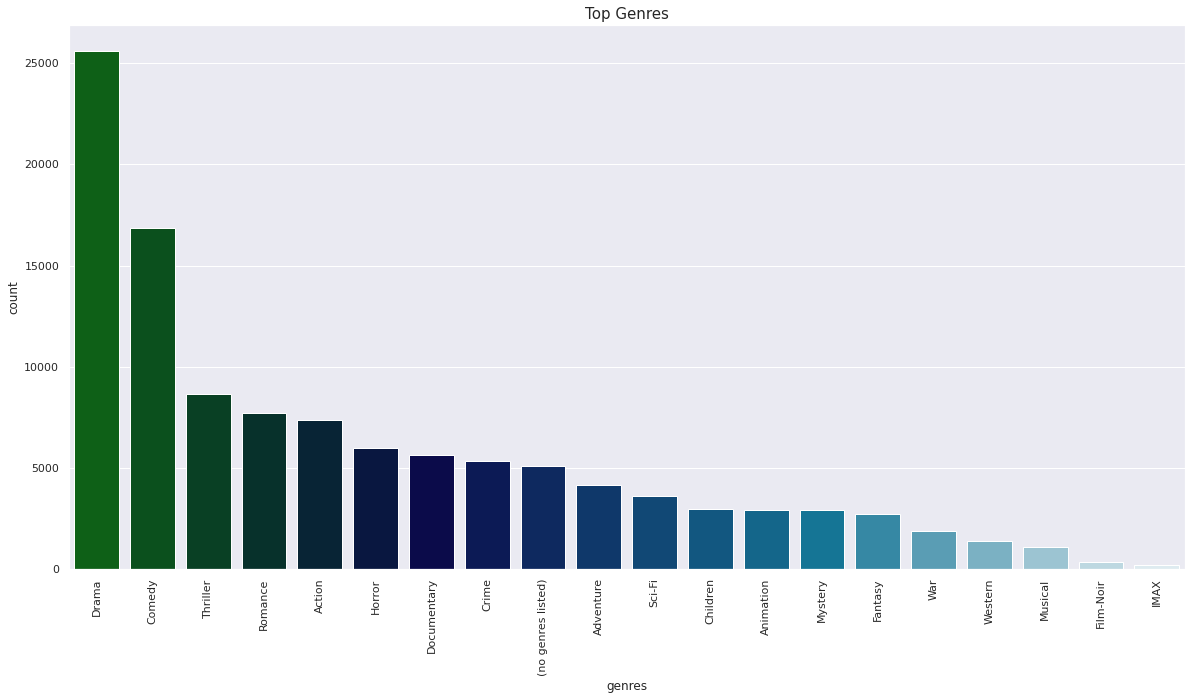

In [29]:
# Create dataframe containing only the movieId and genres
m_genres = pd.DataFrame(movies_df[['movieId', 'genres']],columns=['movieId', 'genres'])

# Split genres seperated by "|" and create a list containing the genres allocated to each movie
m_genres.genres = m_genres.genres.apply(lambda x: x.split('|'))

# Create expanded dataframe where each movie-genre combination is in a seperate row
m_genres = pd.DataFrame([(tup.movieId, d) for tup in m_genres.itertuples() for d in tup.genres],
                             columns=['movieId', 'genres'])

# Ploting top genres in the Dataset
plt.figure(figsize=(20, 10))
gen = m_genres['genres'].explode()
ax=sns.countplot(x=gen, order=gen.value_counts().index[:30],color='b', palette='ocean')
ax.set_title('Top Genres', fontsize=15)
plt.xticks(rotation =90)
plt.show()

# Observation

We see the most common genre by far is Drama ( +25000 movies), followed by Comedy ( +17000 movies) and Thriller ( 10 000 movies). 
The least common genres are IMAX and Film-Noir, which both appear in less than 500 movies.  


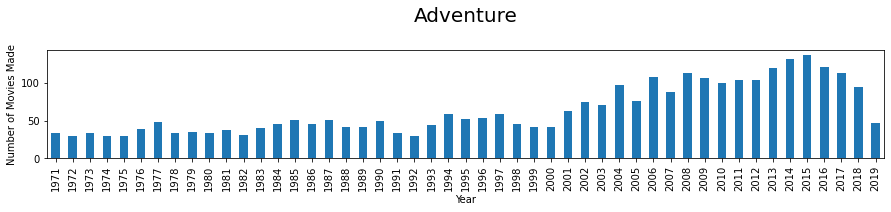

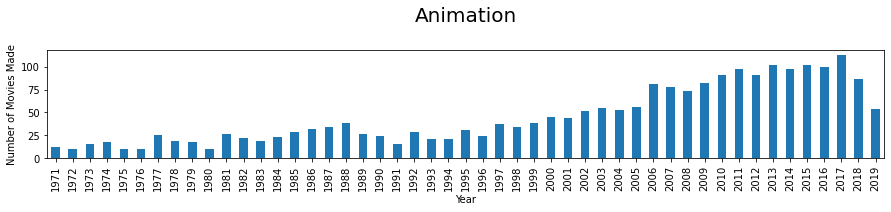

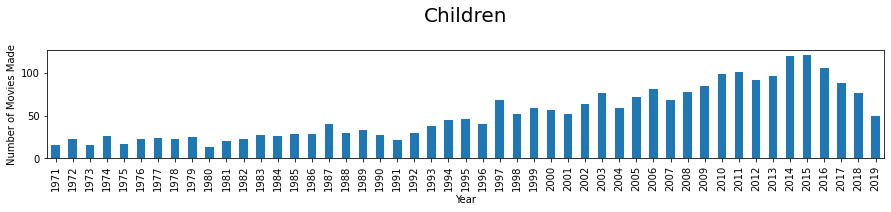

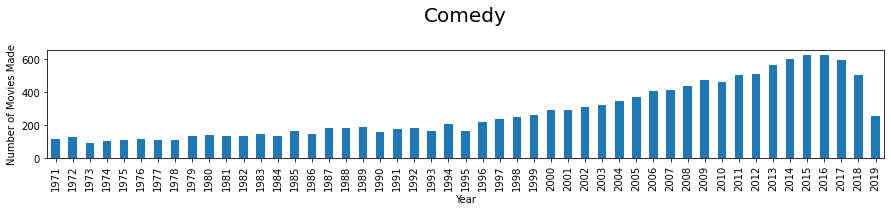

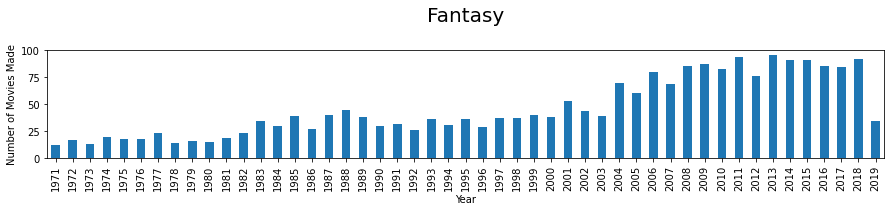

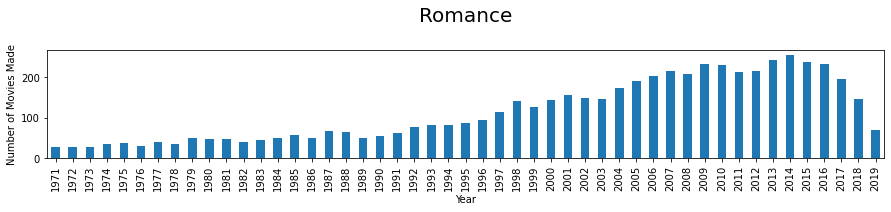

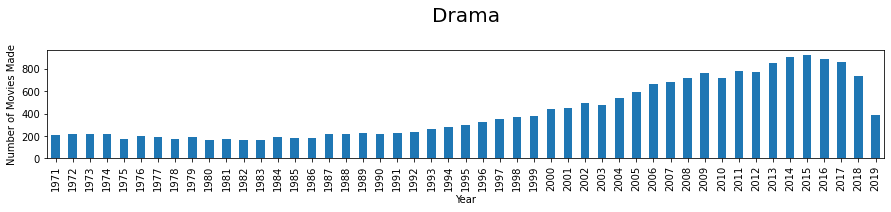

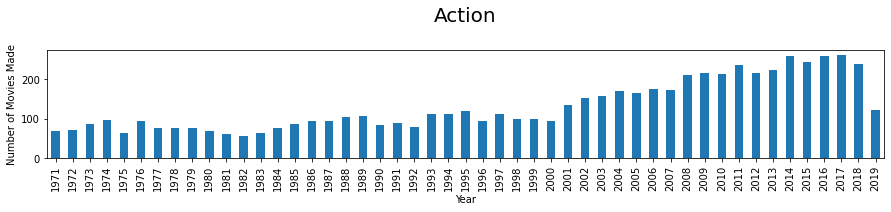

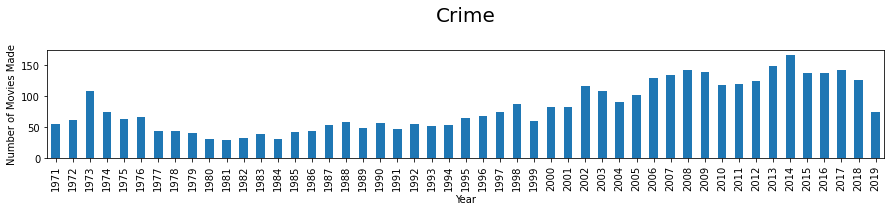

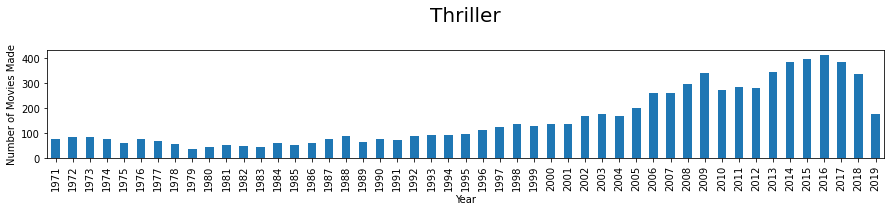

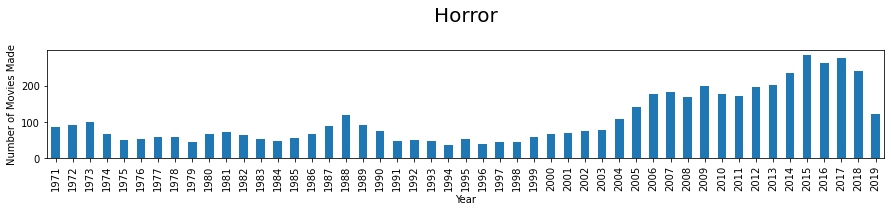

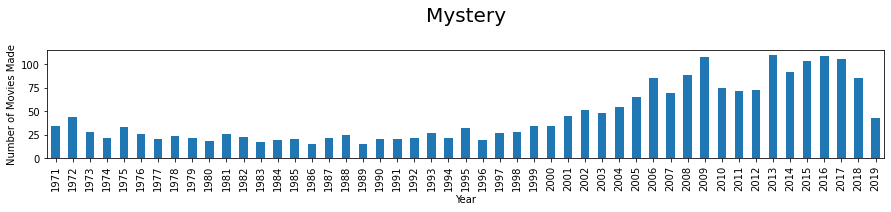

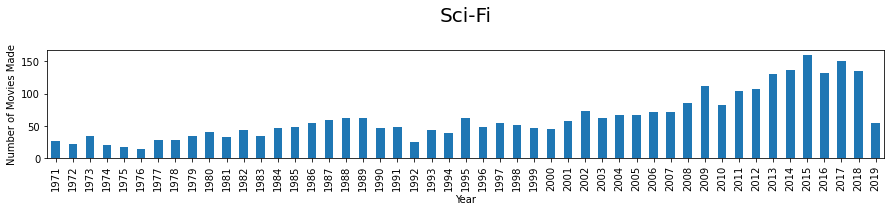

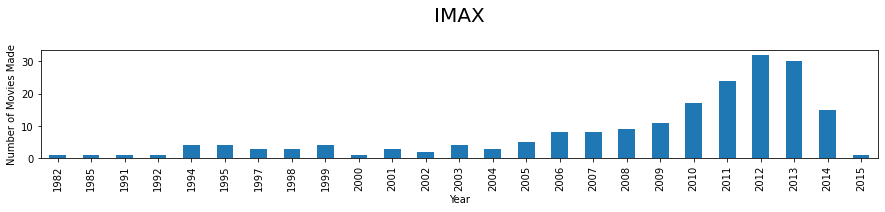

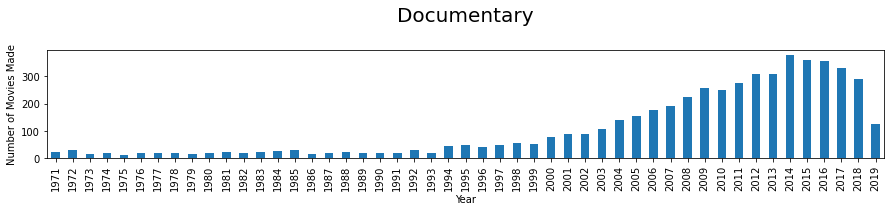

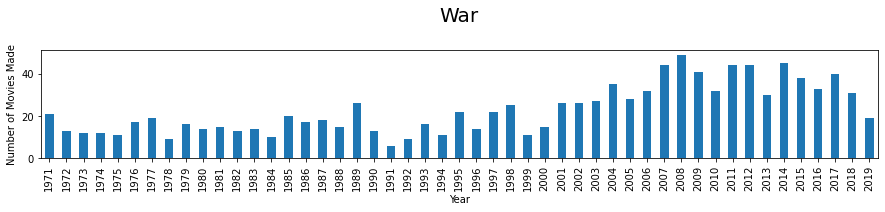

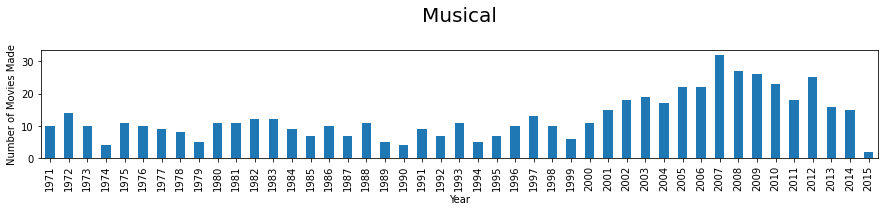

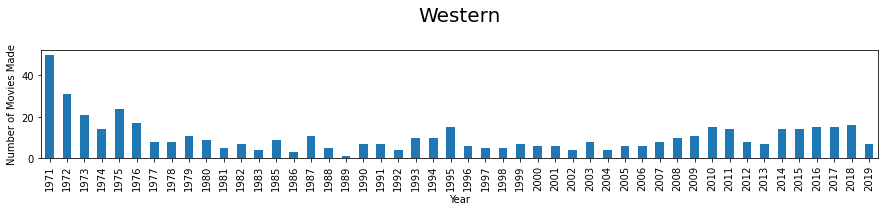

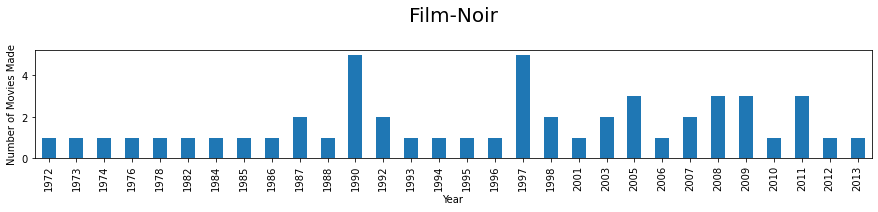

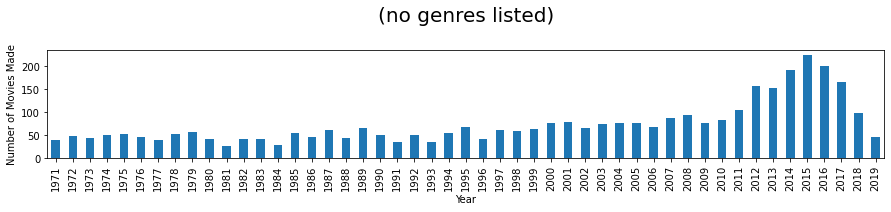

In [8]:
# Add a 'year' column to the movies dataframe that contains the release year of each movie
years = movies_df.title.apply(lambda x: re.findall(r'\((.[\d]+)\)', x))
movies_df['year'] = years.str[-1]

# Create a dataframe containing the year and genres for each movie
genres_per_year = pd.merge(m_genres, movies_df[['movieId', 'year']], on='movieId', how='left')

# Create a list containing all the unique genres present in the dataframe
unique_genres = list(m_genres.genres.unique())

# Plot the number of movies released under each genre from 1970 until 2019
for genre in unique_genres:
    plot = plt.figure(figsize=(15, 2))
    plt.xlabel('Year')
    plt.ylabel('Number of Movies Made')
    plt.title(f'{genre}\n', fontsize=20)
    genres_per_year[genres_per_year.genres == genre][genres_per_year.year.astype(float)
                                                    > 1970].year.value_counts().sort_index().plot(kind='bar',
                                                                                                color='tab:blue')

plt.show()

# Observation

For most of the genres there is a gradual increase from 1970 to 2019 as more films were being made per year.
The exceptions were western which has decreased from 1970 to 2019 and Film Noir which doesnt have a stable trend in number of movies over time

# **Years with most released Movies**

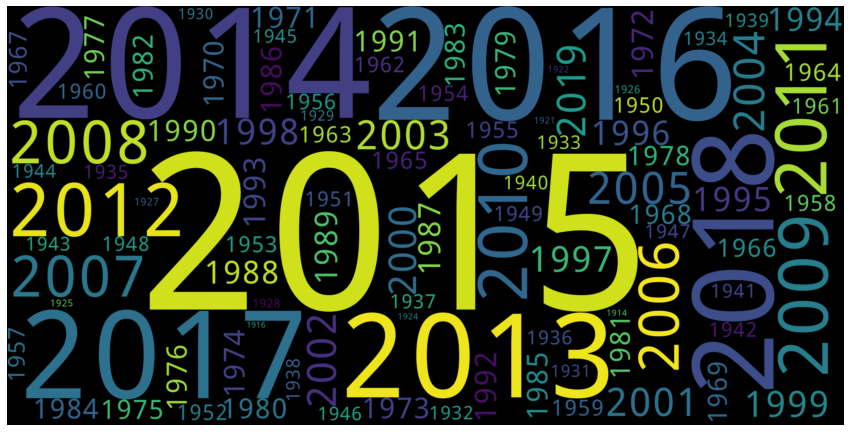

In [9]:
years = movies_df['year'].value_counts()

#create a word cloud with max 100 
wordcloud = WordCloud(max_words=100, background_color='black', height=2000, width=4000).generate_from_frequencies(years)
plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

### Observations: 
* from the above word cloud we can see 2015, 2016, 2014, 2017, 2018 have the most frequency. It is evident that more movies were released in the 2000s, which is possible due to the invention of treaming technologies.


* But let us get more information about this, we will now plot a graph that will give us a better visual of the years vs the number of released movies.

Text(0.5, 1.0, 'TOTAL MOVIES RELEASED PER YEAR')

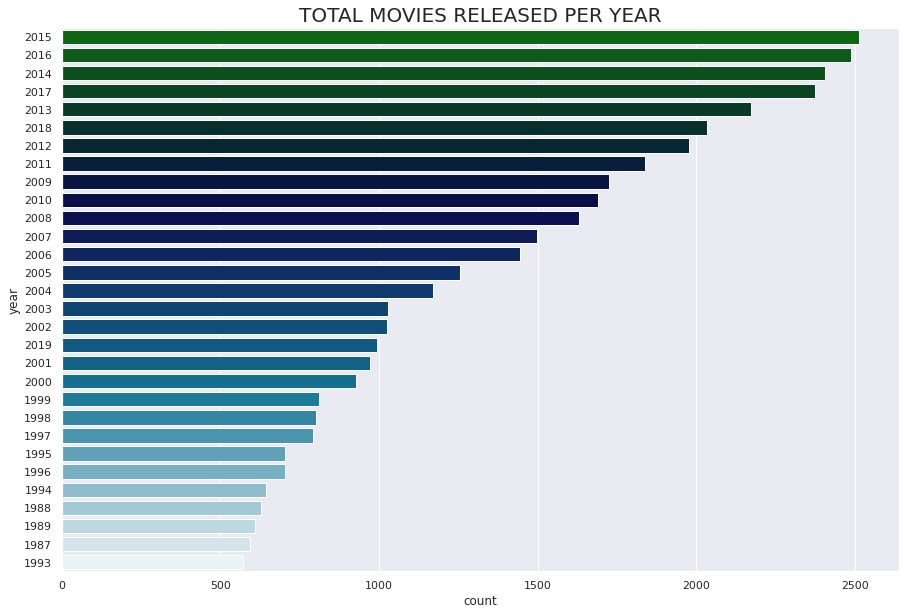

In [28]:
# Plot movies released per year
plt.figure(figsize=(15,10))
sns.set(style="darkgrid")
ax = sns.countplot(y=movies_df['year'], data=movies_df, order=movies_df['year'].value_counts().index[0:30], palette="ocean")
ax.set_title('TOTAL MOVIES RELEASED PER YEAR', fontsize= 20)

# Observation
* There is an sharp increase in the number of movies released from year 2000

* 2015 has the most released movies with over 2500 movies, least movies were released in 1993 with less than 700 movies released.

# **Analyses**

 1880 - 1930
 
 The first projected movie to a paying audience was in Paris 1895. 
 These were the early stages, at this point movie viewing was basic,
 in __black and white and had no sound__ ,by 1914 several national 
 film industries were established. As more people paid to see movies,
 the industry which grew around them was prepared to invest more money 
 in the production and distribution.
 
 
 
 1930 - 1940
  
 Color was used in films such as __The Wizard of Oz__,from 1935 nearly
 all movies had synchronized sound.The introduction of sound and color 
 gave rise to __‘Golden Age of Hollywood’__ at this stage Cinema was the 
 most popular form of entertainment with people attending cinemas __twice a week__.
  
 
 
 1940 - 1980
 
 We see improvements in cinemas such as __wider screens and better audio.__
 From this point on movie theaters had __better customer experiences__ with
 snacks being served and emphasis on comfort and luxury.

 1980 - 1990
 
 First medium of distribution was invented __VHS__, this widened the range of
 additional customers for movie studios as we see with the __huge spike on the graph__.
 This allowed studios to sell movies directly to customers without the need for them to
 go to Cinemas. This business model was __highly profitable__ and created  new markets 
 such as __rental stores__ which made it more convenient for customers
 
 
 1990 - 2009
 
 __DVD’s became mainstream__, forms of media got cheaper and more accessible to 
 the public, the downfall was caused by the disruption of copying rights.
 A lot of DVD’s were easier to copy  which made it more accessible to people 
 and easy to share.The 2008 financial crisis also played a part in less movies
 being released ( Mitchell, 2021).
 
 2008 +
 
 As the Internet came along which meant easy exchange of media. The industry
 had to adapt to changes that resulted in less movies being released and more
 focus on existing movies, creating rights and properties that can be licensed
 to Streaming platforms such as Netflix,Hulu Amazon etc. (A very short history of cinema 2020)

# Rating Distribution

In [11]:

num_users = len(train_df['userId'].unique())
movies_rated = len(train_df['movieId'].unique())

print("Number of Users: ", num_users)
print("Movies Rated: ", movies_rated)

Number of Users:  162541
Movies Rated:  48213


### Users with most ratings

Here we sampled 20 users to explore how many times individual users made ratings. It is evident that most users rated movies less than 100 times.

Text(0, 0.5, 'Number of Ratings')

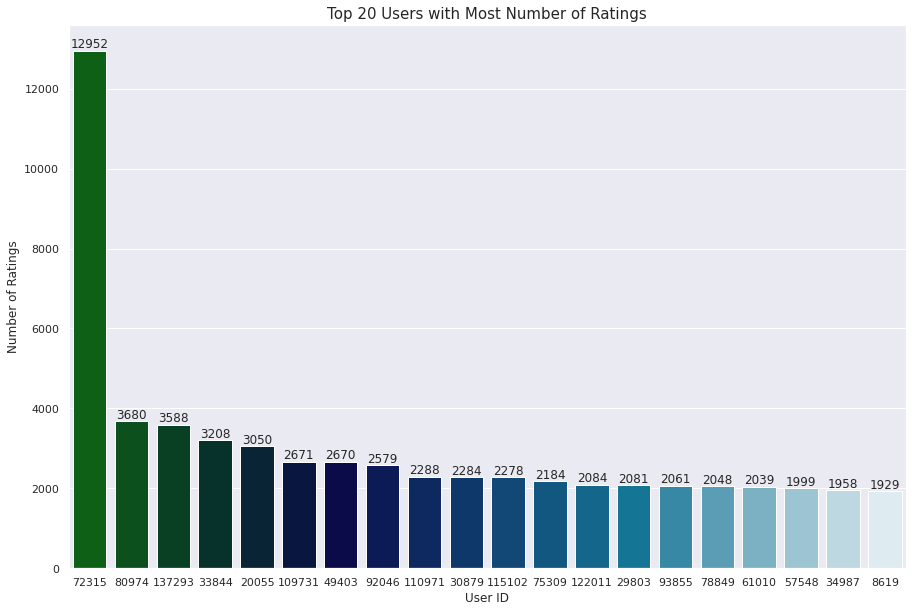

In [27]:
# create figure with white grid style
plt.figure(figsize=(15,10))
sns.set_style("darkgrid") 

# use user id data from train df
# plot barplot
data = train_df['userId'].value_counts(ascending=False).head(20)
fig = sns.barplot(x=data.index, y=data, order=data.index, palette='ocean')

for p in fig.patches:
        fig.text(p.get_x() + p.get_width()/2, p.get_height(), '%d' % int(p.get_height()), fontsize=12, ha='center', va='bottom')

# add title and label
plt.title("Top 20 Users with Most Number of Ratings", size=15)
plt.xlabel("User ID", size=12)
plt.ylabel("Number of Ratings", size=12)

In [13]:
# Total Number of ratings by the top 20 Users
tot_rating = train_df['userId'].value_counts().head(20).sum()
tot_movies = train_df["movieId"].nunique()
print("These Top 20 Users have provided a total of " + str(tot_rating) + " ratings together for " + str(tot_movies) + " movies")

These Top 20 Users have provided a total of 59631 ratings together for 48213 movies


### Observations :

* User ID 72315 has more ratings compared to other users

*  Top 20 users have provided 59631 ratings for the 48213 movies


Next we sampled another 50 users to explore the average rating that users give to movies. Most movies are rated between 3 and 4

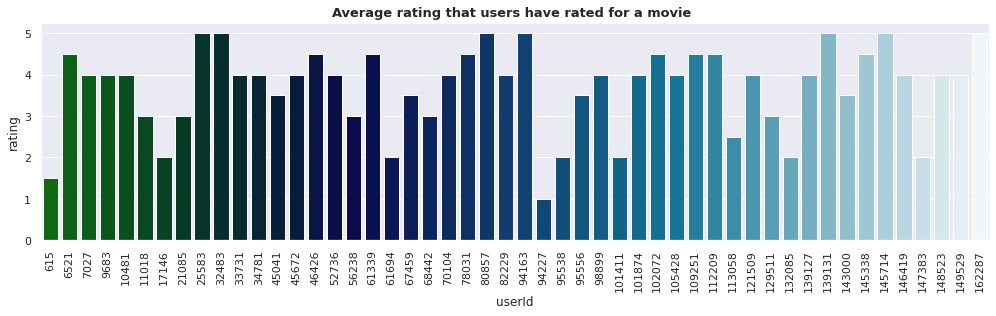

In [26]:

plot = plt.figure(figsize=(17, 4))
plt.figtext(.51, .85, 'Average rating that users have rated for a movie\n',
            fontsize=13, ha='center', fontweight='bold')
sns.barplot(x='userId', y='rating',
            data=train_df.sample(n=50, random_state=27).sort_values('rating'), palette='ocean')
plt.xticks(rotation='vertical')

plt.show()

In [15]:

users = train_df.groupby('userId').agg(num_ratings=('movieId', 'size'),
                                       average_rating=('rating', 'mean')).reset_index()

users.describe()

,userId,num_ratings,average_rating
count,162541.00000,162541.000000,162541.000000
mean,81271.00000,61.523173,3.678923
std,46921.68939,107.410889,0.506977
min,1.00000,1.000000,0.500000
25%,40636.00000,14.000000,3.376404
50%,81271.00000,28.000000,3.701493
75%,121906.00000,65.000000,4.000000
max,162541.00000,12952.000000,5.000000


Observations

* The average rating given across all movies is 3.68(out of 5) with 75% of movies being rated more than 4(out of 5)

* The average rating across all movies is skewed to the right. Most ratings are between 3 and 4. 

* There are very few movies rated less than 3.4 and that is indicated by the outliers outside of the 1st quantile.
* There are also very few movies rated at 5 and thats indicated by the outliers after the 4th quantile




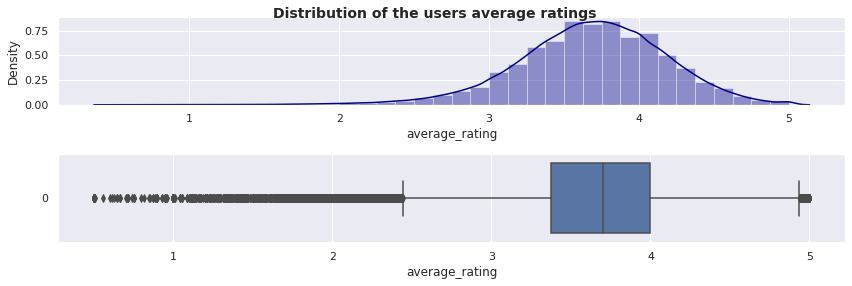

In [16]:

plot, axes = plt.subplots(2, 1, figsize=(12, 4))
plt.figtext(.51, .95, 'Distribution of the users average ratings', fontsize=14, ha='center',
            fontweight='bold')
sns.distplot(users['average_rating'], hist=True, kde=True,
             bins=int(180/5), color='darkblue', ax=axes[0])

sns.boxplot(data=users['average_rating'],  orient='h', ax=axes[1])
plt.xlabel('average_rating')

plt.tight_layout()
plt.show()


Next lets explore and visualise if there is a relationship between the total number of ratings a user made and their average ratings.

The outlier made it difficult to see all the points but we are still able to deduce that there is a pattern between number of ratings and average rating. The more people rate movies, the more their ratings converge to the median rating of 3.

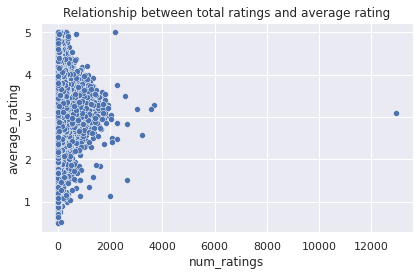

In [17]:
# Scatter plot of total rating vs average rating
plt.title('Relationship between total ratings and average rating', fontsize=12)
sns.scatterplot(x=users['num_ratings'], y=users['average_rating'], data=users)
plt.tight_layout()
plt.show()


## Movies popularity

We will use the product of average rating and the number of ratings a film recieved to determine its popularity.

In [19]:
rating_df = train_df.merge(movies_df, on="movieId", how="inner").dropna(inplace=False)
rating_df.head(2)

,userId,movieId,rating,timestamp,title,genres,year
0,5163,57669,4.0,1518349992,In Bruges (2008),Comedy|Crime|Drama|Thriller,2008
1,87388,57669,3.5,1237455297,In Bruges (2008),Comedy|Crime|Drama|Thriller,2008


In [21]:
# Extract and display the 10 most popular films in the dataset 
# Determine the average rating and number of ratings for each movie
ratings_mean_count = pd.DataFrame(rating_df.groupby(['title'])[['rating']].mean())
ratings_mean_count['rating_counts'] = pd.DataFrame(rating_df.groupby(['title'])['rating'].count())
ratings_mean_count['popularity'] = pd.DataFrame(rating_df.groupby(['title'])['rating'].count()*rating_df.groupby(['title'])['rating'].mean())

ratings_mean_count = ratings_mean_count.sort_values(by='popularity', ascending=False).head(10)
ratings_mean_count.head(10)

,rating,rating_counts,popularity
title,,,
"Shawshank Redemption, The (1994)",4.417624,32831,145035.0
Pulp Fiction (1994),4.195097,31697,132972.0
Forrest Gump (1994),4.047216,32383,131061.0
"Silence of the Lambs, The (1991)",4.144172,29444,122021.0
"Matrix, The (1999)",4.154253,29014,120531.5
Star Wars: Episode IV - A New Hope (1977),4.111811,27560,113321.5
Schindler's List (1993),4.247625,24004,101960.0
Fight Club (1999),4.227906,23536,99508.0
Star Wars: Episode V - The Empire Strikes Back (1980),4.146236,22956,95181.0


### Observations:

* An interesting thing to note is top 10 most popular movies are older, with none of the movies more recent than 1999
* This just could be because these movies have been around longer and have been rated more as a result

### wordcloud of movies that obtained highest ratings

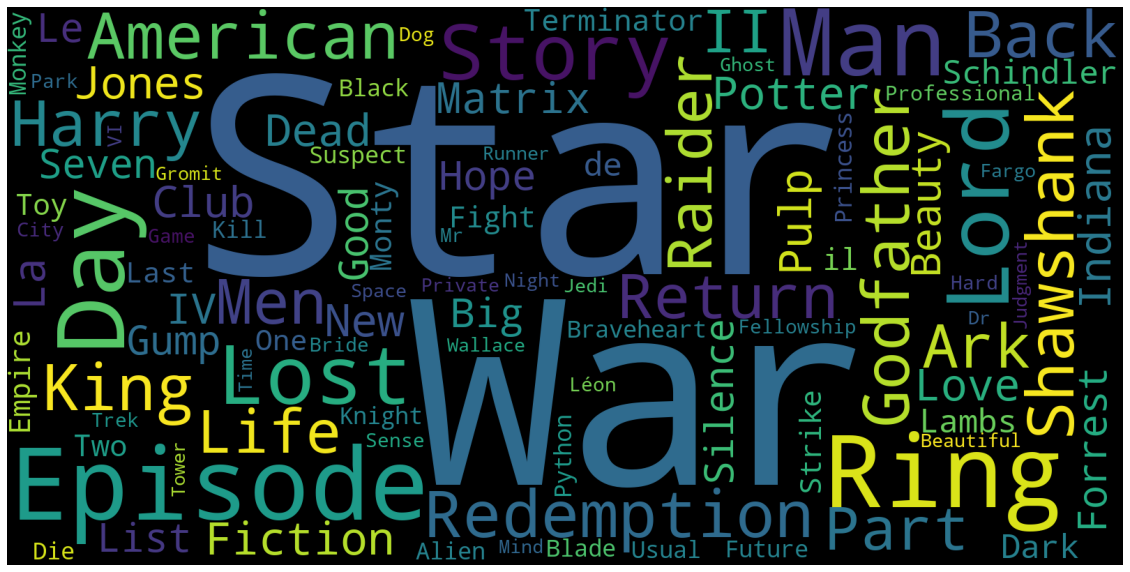

In [23]:
rating_df.rating = rating_df.rating.apply(lambda x: int(x))
High_rating_df =rating_df[rating_df['rating']==5]

Low_rating_df =rating_df[rating_df['rating']==0]

High_rating_list =str(list(High_rating_df['title']))
Low_rating_list =str(list(Low_rating_df['title']))


high_r = rating_df
plt.figure(figsize = (20,20))
wc = WordCloud(background_color = "black", max_words = 100 , 
               width = 1600 , height = 800,collocations=False).generate(High_rating_list)
plt.axis("off")
plt.imshow(wc)

### wordcloud of movies that obtained lowest ratings

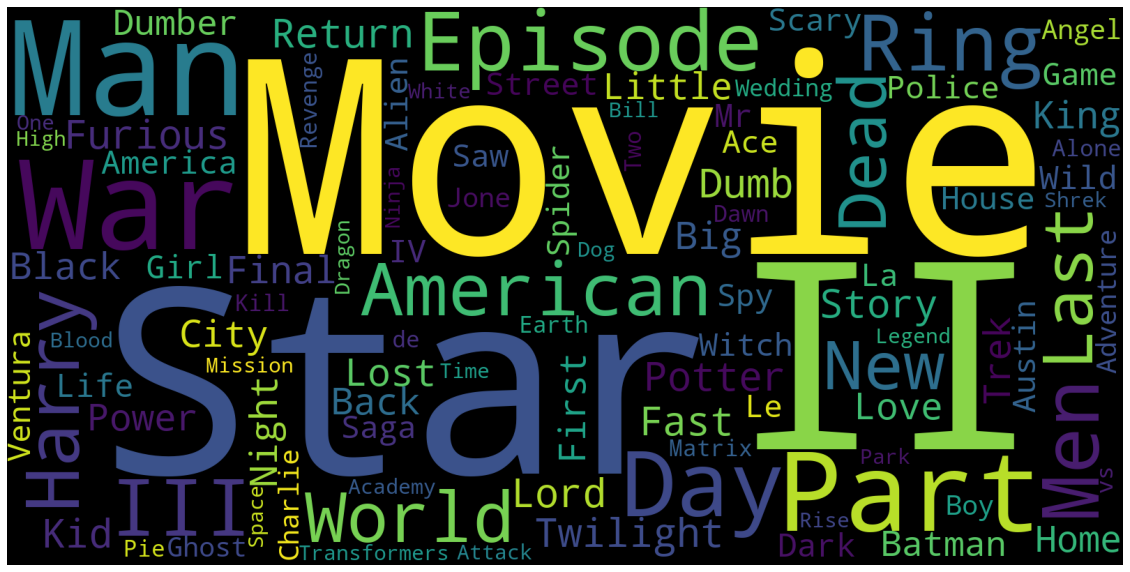

In [24]:
plt.figure(figsize = (20,20))
wc = WordCloud(background_color = "black", max_words = 100 , 
               width = 1600 , height = 800,collocations=False).generate(Low_rating_list)
plt.axis("off")
plt.imshow(wc)

Some  movies such as the star, wars, man, appears in the two word plot.This means its possible for a movie to recieve the highest and the lowest rating from different users.

## Tags

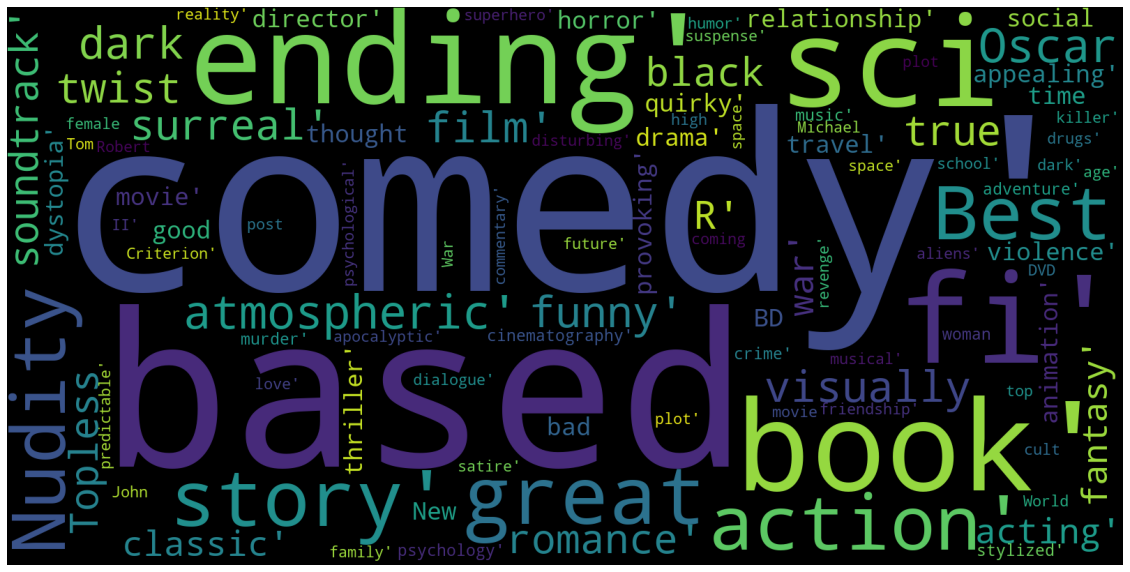

In [30]:
tags_2 =str(list(tags_df['tag']))
plt.figure(figsize = (20,20))
wc = WordCloud(background_color = "black", max_words = 100 , width = 1600 , height = 800,
               collocations=False).generate(tags_2)
plt.axis("off")
plt.imshow(wc)

In [32]:
# Create list containing the counts
# for each tag in the tags dataframe and sort in descending order of counts
tag_counts = tags_df['tag'].value_counts(ascending=False)
# Create dataframe showing the top 10 most common tags and their counts
most_common_tags = list(zip(tag_counts[:10].index, tag_counts[:10]))
most_common_tags = pd.DataFrame(most_common_tags)
most_common_tags.columns = ['tag', 'count']
most_common_tags.style.background_gradient(cmap='Blues')

,tag,count
0,sci-fi,8330
1,atmospheric,6516
2,action,5907
3,comedy,5702
4,surreal,5326
5,based on a book,5079
6,twist ending,4820
7,funny,4738
8,visually appealing,4526
9,dystopia,4257


## References
* Netflix Research. (2022). Retrieved 29 April 2022, from https://research.netflix.com/research-area/recommendations

* A very short history of cinema. National Science and Media Museum. (2020, June 9). Retrieved April 29, 2022, from https://www.scienceandmediamuseum.org.uk/objects-and-stories/very-short-history-of-cinema 
*  Mitchell, E. (2021, September 30). Cinerama in the UK: 3-strip cinema in Bradford, past and present. National Science and Media Museum blog. Retrieved April 29, 2022, from https://blog.scienceandmediamuseum.org.uk/cinerama-in-the-uk-the-history-of-3-strip-cinema-in-pictureville-cinema/ 